<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Differences-in-currents-depending-on-z" data-toc-modified-id="Differences-in-currents-depending-on-z-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Differences in currents depending on z</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li></ul></li><li><span><a href="#Systematic-differences" data-toc-modified-id="Systematic-differences-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Systematic differences</a></span></li><li><span><a href="#How-does-the-gap-behaves-as-a-function-of-tau_z" data-toc-modified-id="How-does-the-gap-behaves-as-a-function-of-tau_z-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>How does the gap behaves as a function of tau_z</a></span><ul class="toc-item"><li><span><a href="#Weight-for-different-values-of-tau_z_pre" data-toc-modified-id="Weight-for-different-values-of-tau_z_pre-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Weight for different values of tau_z_pre</a></span></li><li><span><a href="#Connection-through-a-bridge" data-toc-modified-id="Connection-through-a-bridge-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Connection through a bridge</a></span></li></ul></li><li><span><a href="#Real-gap" data-toc-modified-id="Real-gap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Real gap</a></span></li></ul></div>

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

# Preamble

## General parameters

In [17]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -3.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 1.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 8
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

# Differences in currents depending on z

## An example

In [18]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 5
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.500
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's', 'a', 'beta']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 14.1 ms


pattern sequence [0, 1, 2, 3, 4]
times [0.099, 0.105, 0.105, 0.105, 0.109]
T_calculated 0.105


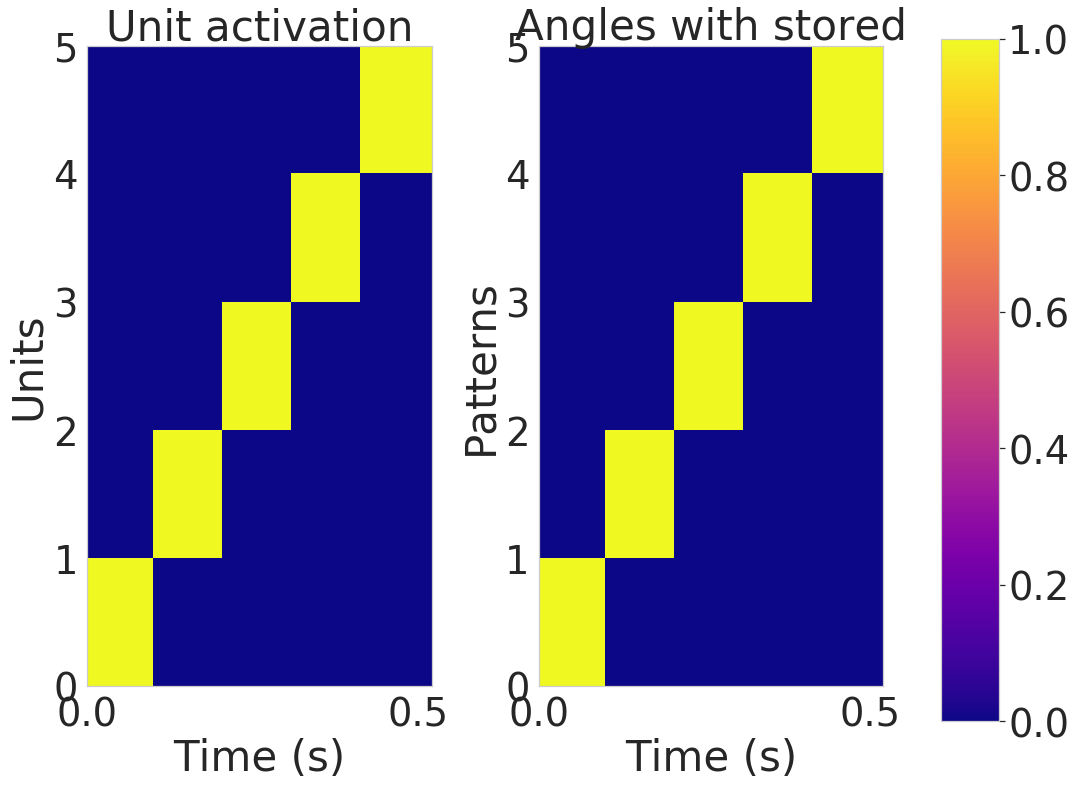

In [19]:
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 1.0 * T_persistence * n_patterns + T_cue
manager.nn.z_pre[0] = 1.0

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

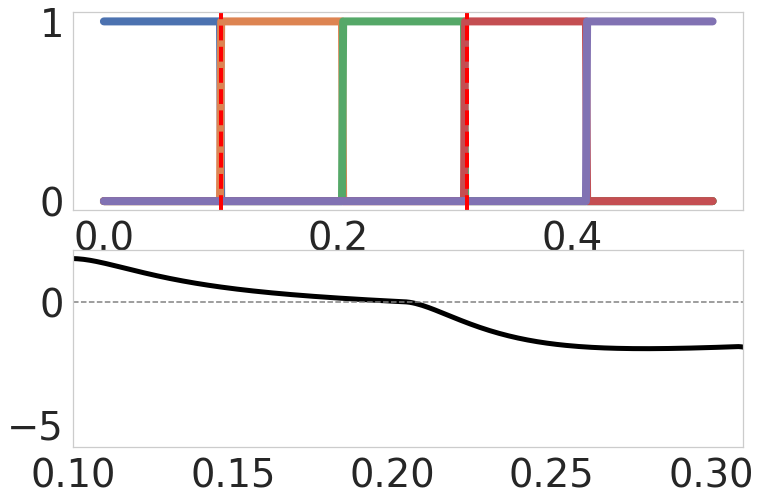

In [31]:
I = manager.history['i']
O = manager.history['o']
Z_pre = manager.history['z_pre']
S = manager.history['s']
A = manager.history['a']
Beta = manager.history['beta']


fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for index in range(n_patterns):
    lw += 1.5
    ax1.plot(manager.time, O[:, index], lw=8, color=colors[index])

ax2.plot(manager.time, S[:, 1] - S[:, 2], lw=5, color='black')
x_lim1 = 0.100
x_lim2 = 0.310
ax1.axvline(x_lim1, ls='--', color='red', lw=4)
ax1.axvline(x_lim2, ls='--', color='red', lw=4)

ax2.set_xlim([x_lim1, x_lim2])

ax2.axhline(0, ls='--', color='gray')

# Systematic differences

In [45]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_pre_vector = [0.025, 0.050, 0.75, 0.100, 0.125, 0.150]
data_dic = {}

for tau_z_pre in tau_z_pre_vector:
    
    tau_z_post = 0.005

    hypercolumns = 1
    minicolumns = 5
    n_patterns = minicolumns

    # Training protocol
    training_times_base = 0.100
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = 0.000
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 0.500
    epochs = 1
    T_persistence = 0.100

    # Manager properties
    values_to_save = ['o', 'i', 'z_pre', 's', 'a', 'beta']

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)


    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

    T_cue = 1.0 * manager.nn.tau_s
    T_recall = 1.0 * T_persistence * n_patterns + T_cue
    manager.nn.z_pre[0] = 1.0

    # Success
    nr = representation.network_representation
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux


    S = manager.history['s']
    data_dic[tau_z_pre] = [S, np.copy(manager.time)]


CPU times: user 364 ms, sys: 4 ms, total: 368 ms
Wall time: 368 ms


In [46]:
data_dic.keys()

dict_keys([0.025, 0.05, 0.75, 0.1, 0.125, 0.15])

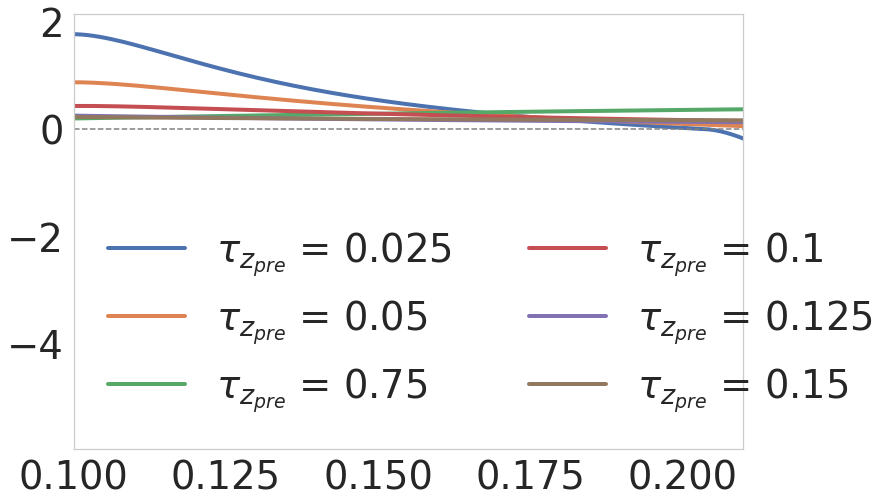

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)

counter = 0
for tau_z_pre, aux in data_dic.items():
    S, time = aux
    ax.plot(time, S[:, 1] - S[:, 2], color=colors[counter], lw=4, label=r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre))
    counter += 1
    
x_lim1 = 0.100
x_lim2 = 0.210
ax.set_xlim([x_lim1, x_lim2])
ax.axhline(0, ls='--', color='gray')
ax.legend(frameon=False, ncol=2)
#ax1.axvline(x_lim1, ls='--', color='red', lw=4)
#ax1.axvline(x_lim2, ls='--', color='red', lw=4)



# How does the gap behaves as a function of tau_z

In [52]:
tau_z = 0.025
T = 0.100

def return_gap(tau_z, T):
    
    M = (1 - np.exp(- T / tau_z))
    w_gap = np.log10((T - tau_z * M) / (tau_z * M **2))
    
    return w_gap

In [69]:
T_list = [0.025, 0.050, 0.100]
w_gap_list = []
tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)
for T in T_list:
    w_gap_list.append(return_gap(tau_z_pre_vector, T))

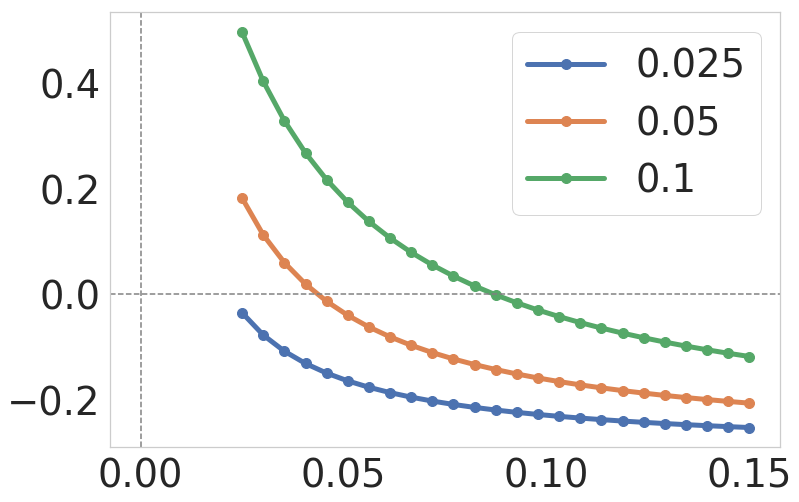

In [73]:
counter = 0
for w_gap_vector in w_gap_list:
    plt.plot(tau_z_pre_vector, w_gap_vector, 'o-', lw=5, ms=10, label=str(T_list[counter]))
    counter += 1
plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')
plt.legend()

## Weight for different values of tau_z_pre

In [86]:
%%time

tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)

W_list = []
for tau_z_pre in tau_z_pre_vector:
    
    sigma_out = 0.0    
    tau_z_post = 0.001
    hypercolumns = 1
    minicolumns = 5
    n_patterns = minicolumns

    # Training protocol
    training_times_base = 0.100
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = 0.000
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 0.500
    epochs = 1
    T_persistence = 0.100

    # Manager properties
    values_to_save = ['o']

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    
    W_list.append(np.copy(nn.w))

CPU times: user 304 ms, sys: 8 ms, total: 312 ms
Wall time: 304 ms


In [87]:
w_gap = [W_list[i][1, 1] - W_list[i][2, 1] for i in range(tau_z_pre_vector.size)]

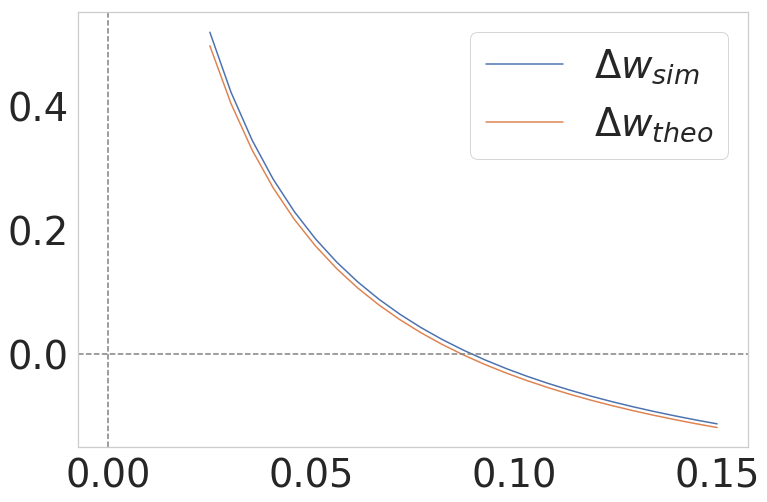

In [90]:
w_theo = return_gap(tau_z_pre_vector, training_times_base)

plt.plot(tau_z_pre_vector, w_gap, label=r'$\Delta w_{sim}$')
plt.plot(tau_z_pre_vector, w_theo, label=r'$\Delta w_{theo}$')

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')
plt.legend()

## Connection through a bridge

In [99]:
def w_bridge(T_total, tau_z_pre, T_training, n):
    
    M1 = (1 - np.exp(-T_training / tau_z_pre))
    
    return np.log10((T_total * tau_z_pre * M1**2)/(T_training ** 2)) - (n * T_training / tau_z_pre)

In [104]:
tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)
n = 4
T_total_list = [5, 10, 50, 100]
T_total = 20.0
T_training = 0.100
w_bridge_vector = w_bridge(T_total, tau_z_pre_vector, T_training, n)

Text(0.5, 0, '$\\tau_{z_{pre}}$')

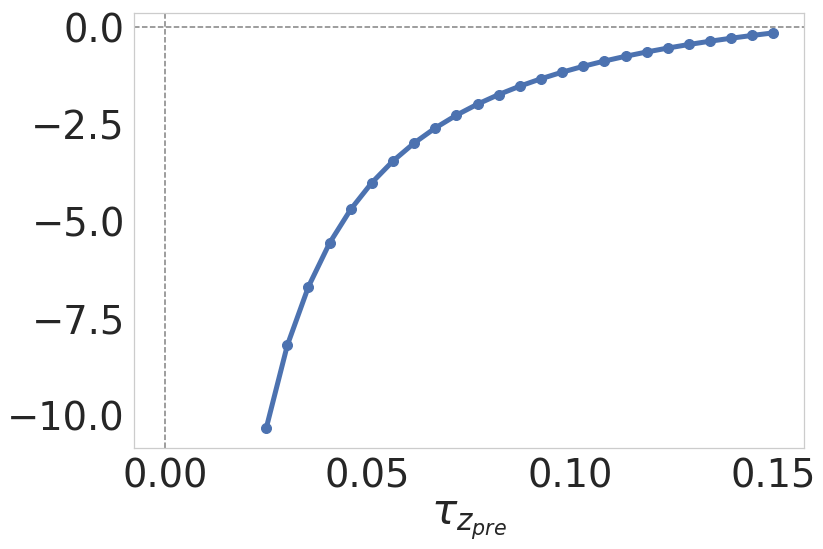

In [107]:
plt.plot(tau_z_pre_vector, w_bridge_vector, 'o-', ms=10, lw=5)

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel(r'$\tau_{z_{pre}}$')

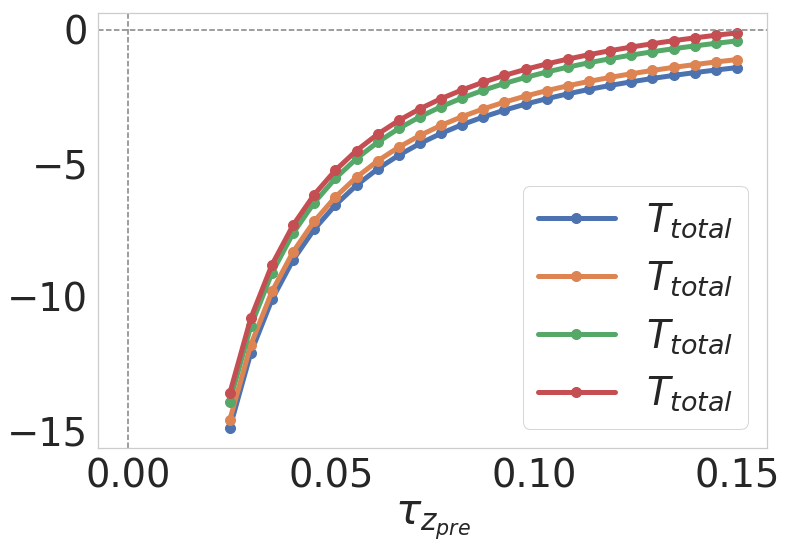

In [109]:
tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)
n = 4
T_total_list = [5, 10, 50, 100]
for T_total in T_total_list:
    T_training = 0.100
    w_bridge_vector = w_bridge(T_total, tau_z_pre_vector, T_training, n)

    plt.plot(tau_z_pre_vector, w_bridge_vector, 'o-', ms=10, lw=5, label=r'$T_{total}$')

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel(r'$\tau_{z_{pre}}$')
plt.legend()

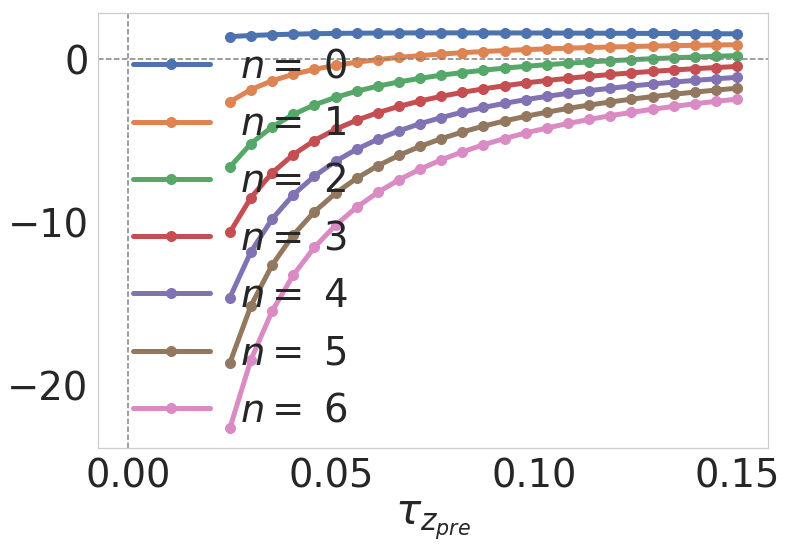

In [113]:
tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)
n = 4
n_list = [0, 1, 2, 3, 4, 5, 6]
T_total = 10.0
T_training = 0.100
for n in n_list:
    w_bridge_vector = w_bridge(T_total, tau_z_pre_vector, T_training, n)

    plt.plot(tau_z_pre_vector, w_bridge_vector, 'o-', ms=10, lw=5, label=r'$n = $ ' + str(n))

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel(r'$\tau_{z_{pre}}$')
plt.legend(frameon=False)

# Real gap

In [119]:
def w_bridge(T_total, tau_z_pre, n, epsilon=10e-6):
    
    M1 = (1 - np.exp(-T_training / tau_z_pre))
    
    return np.log10(tau_z_pre * M1**2) - (n * T_training / tau_z_pre) - np.log10(epsilon)

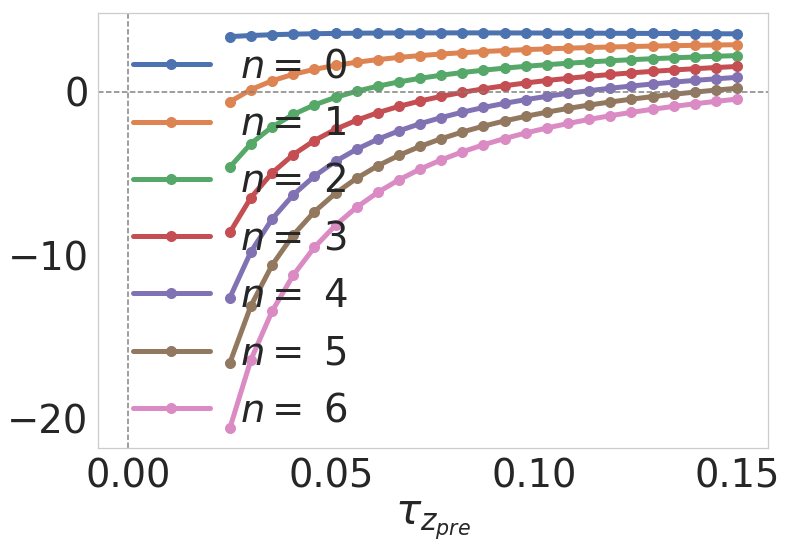

In [121]:
tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)
n = 4
n_list = [0, 1, 2, 3, 4, 5, 6]
T_total = 10.0
T_training = 0.100
for n in n_list:
    w_bridge_vector = w_bridge(T_total, tau_z_pre_vector, n, epsilon=10e-6)

    plt.plot(tau_z_pre_vector, w_bridge_vector, 'o-', ms=10, lw=5, label=r'$n = $ ' + str(n))

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel(r'$\tau_{z_{pre}}$')
plt.legend(frameon=False)

(0, 10)

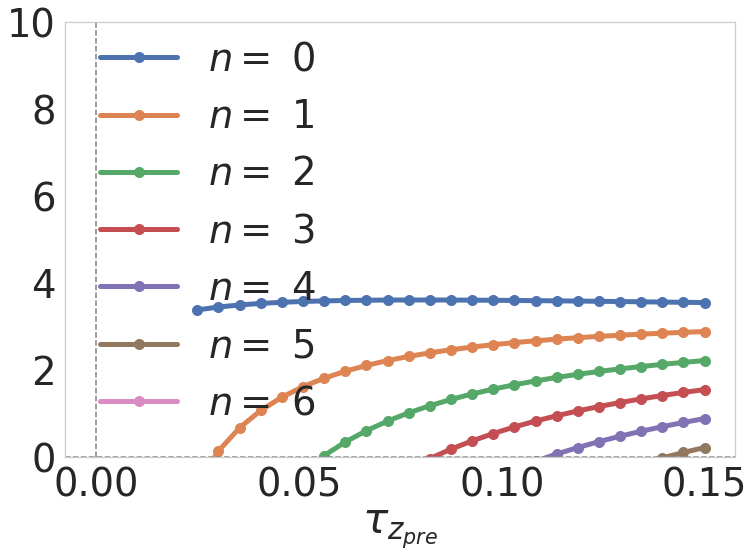

In [122]:
tau_z_pre_vector = np.linspace(0.025, 0.150, num=25)
n = 4
n_list = [0, 1, 2, 3, 4, 5, 6]
T_total = 10.0
T_training = 0.100
for n in n_list:
    w_bridge_vector = w_bridge(T_total, tau_z_pre_vector, n, epsilon=10e-6)

    plt.plot(tau_z_pre_vector, w_bridge_vector, 'o-', ms=10, lw=5, label=r'$n = $ ' + str(n))

plt.axhline(0, ls='--', color='gray')
plt.axvline(0, ls='--', color='gray')

plt.xlabel(r'$\tau_{z_{pre}}$')
plt.legend(frameon=False)

plt.ylim([0, 10])